# IN4080: obligatory assignment 2 (Autumn 2024)
 
Mandatory assignment 1 consists of three parts. In Part 1, you will experiment with a greedy sequence labeling model and investigate the impact of different feature types on **part-of-speech tagging** performance (9 points + 2 optional bonus points). In Part 2, you will evaluate the best model on a different task, **named entity recognition** (5 points). In Part 3, you will return to the **text classification task** and implement a simple feed-forward neural network for it (6 points).

You should answer all three parts. You are required to get at least 12/20 points to pass. The most important is that you try to answer each question (possibly with some mistakes), to help you gain a better and more concrete understanding of the topics covered during the lectures. In the first part, there are also bonus questions for those of you who would like to deepen their understanding of the topics covered by this assignment.

- We assume that you have read and are familiar with IFI’s requirements and guidelines for mandatory assignments, see [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-mandatory.html) and [here](https://www.uio.no/english/studies/examinations/compulsory-activities/mn-ifi-guidelines.html).
- This is an individual assignment. You should not deliver joint submissions. 
- You may redeliver in Devilry before the deadline (__Sunday, September 29 at 23:59__), but include all files in the last delivery.
- Only the last delivery will be read! If you deliver more than one file, put them into a zip-archive. You don't have to include in your delivery the files already provided for this assignment. 
- Name your submission _your\_username\_in4080\_mandatory\_2_
- You can work on this assignment either on the IFI machines or on your own computer. 

*The preferred format for the assignment is a completed version of this Jupyter notebook*, containing both your code and explanations about the steps you followed. We want to stress that simply submitting code is __not__ by itself sufficient to complete the assignment - we expect the notebook to also contain explanations of what you have implemented, along with motivations for the choices you made along the way. Preferably use whole sentences, and mathematical formulas if necessary. Explaining in your own words (using concepts we have covered through in the lectures) what you have done and reflecting on your solution is an important part of the learning process - take it seriously!

Regarding the use of LLMs (ChatGPT or similar): you are allowed to use them as 'sparring partner', for instance to clarify something you have not understood. However, you are __not__ allowed to use them to generate solutions (either in part or in full) to the assignment tasks.

In this assignment, we'll use the following Python modules: `scikit-learn, pyconll, matplotlib, sentence_transformers`. Make sure you have installed them.

In [7]:
# if you use a virtual environment, you can install the modules like this
# import sys
# !{sys.executable} -m pip install scikit-learn pyconll matplotlib sentence_transformers

## Part 1 – Greedy logistic regression taggers and feature engineering

In the lecture, we have discussed Matthew Honnibal's proposal of a discriminative sequence labelling model with greedy decoding. He argued that an extended set of features is more helpful for tagging than exact (Viterbi) decoding. Therefore, we skip HMMs and the Viterbi algorithm here and focus on models based on logistic regression.

Scikit-learn doesn't contain implementations of sequence labeling models. Therefore, we provide you with some basic code. The code below defines a `GreedyTagger` with a `fit()` function for training and a `predict()` function for prediction/testing. By default, it uses a standard Scikit-learn logistic regression classifier under the hood, which takes a feature vector for a word (and its context) as input and provides the most likely class label as output.

Your task in this part will mainly consist in defining how a word (and its context) is converted to a feature vector.

In [8]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

class GreedyTagger:
    """
        Tagger based on logistic regression or any other classification algorithm supported by Scikit-Learn.
    """

    def __init__(self, feature_function, classifier=LogisticRegression()):
        """
            Creates a GreedyTagger object.

            Args:
                feature_function: A function that transforms the input sequence and the index of the current word into a set of key-value pairs.
                classifier: A Scikit-Learn classifier instance.
        """
        self.features = feature_function
        self.classifier = classifier
        self.vectorizer = DictVectorizer()
        self.label_ids = {}     # mapping from labels to numeric label ids
        self.id_labels = {}     # mapping from numeric label ids to labels

    def fit(self, dataset_X, dataset_Y):
        """
            Trains the tagger. Creates a list of inputs (feature vectors of individual words) and a list of labels (numeric ids) and calls the `fit` function of the base classifier on these lists.

            Args:
                dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.
                dataset_Y: The training data labels, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of labels (e.g. POS-tags or BIO-tags).
        """
        flattened_dataset_X = []      # a flat list of training instances
        flattened_dataset_Y = []      # a flat list of label ids for the training instances
        for sentence_X, sentence_Y in zip(dataset_X, dataset_Y):
            # sentence_X is a list of words
            # sentence_Y is a list of labels, one for each word of the sentence
            history = []
            for i, (x, y) in enumerate(zip(sentence_X, sentence_Y)):
                feature_dict = self.features(sentence_X, i, history)
                flattened_dataset_X.append(feature_dict)
                if y not in self.label_ids:
                    self.label_ids[y] = len(self.label_ids)
                flattened_dataset_Y.append(self.label_ids[y])
                history.append(y)
        transformed_dataset_X = self.vectorizer.fit_transform(flattened_dataset_X)
        transformed_dataset_Y = np.array(flattened_dataset_Y)
        self.id_labels = {self.label_ids[label]: label for label in self.label_ids}
        self.classifier.fit(transformed_dataset_X, transformed_dataset_Y)
        return self
        
    def predict(self, dataset_X):
        """
            Predicts the labels for the input data, sentence by sentence.

            Args:
                dataset_X: The input training data, formatted as a list of lists. Each list item represents a sentence and corresponds to a list of tokens.
            
            Returns:
                list: The predicted labels, in the same format as dataset_X (list of lists).
        """
        predictions = []
        for sentence_X in dataset_X:
            flattened_sentence_X = []
            history = []
            for i, word in enumerate(sentence_X):
                feature_dict = self.features(sentence_X, i, history)
                flattened_sentence_X.append(feature_dict)
            transformed_sentence_X = self.vectorizer.transform(flattened_sentence_X)
            predicted_sentence_Y = self.classifier.predict(transformed_sentence_X)
            predicted_labels_Y = [self.id_labels[y] for y in predicted_sentence_Y]
            predictions.append(predicted_labels_Y)
        return predictions

When instantiating this class, you need to provide a so-called *feature function* that defines how the feature vector is created. In the provided implementation, this is done in two steps:
1. The feature function creates a feature dictionary. Each key of the dictionary defines a one-hot vector, and the value determines which value of the vector will be set to one. For example, the feature dictionary `{"curr_word": "love", "prev_word": "I", "next_word": "fish"}` defines three one-hot vectors, which together represent the word `love` in the sequence `I love fish`. The keys can be chosen freely.
2. The `DictVectorizer` class of Scikit-Learn will convert the feature dictionary to actual one-hot vectors and concatenate them into a single vector. This step is already taken care of in the `fit()` function.

A basic feature function that only uses the current word could look like this (we will use the parameter `history` later, but don't worry about it now):

In [9]:
def basic_features(sentence, i, history):
    features = {"curr_word": sentence[i]}
    return features

The `predict()` function only returns the predicted labels, it doesn't compare them to the ground truth. Here is another function that computes accuracy for the predictions of a dataset. However, the function is incomplete -- it only uses the first sentence of the dataset.

**Task 1.1** (1 point): Modify the function to take into account all sentences of the dataset. The easiest way to achieve this is to flatten a list of lists into a single list, so you'll only have to call the `accuracy_score` function once.

In [10]:
def tagging_accuracy(dataset_Y_true, dataset_Y_pred):
    ## CHANGE CODE HERE
    # we can use to solve this a list comprehensions to basically flatten the lists
    flat_Y_true = [tag for sentence in dataset_Y_true for tag in sentence]
    flat_Y_pred = [tag for sentence in dataset_Y_pred for tag in sentence]

    # now we use the flatten lists to evaluate the accuracy
    acc = sklearn.metrics.accuracy_score(flat_Y_true, flat_Y_pred) # --> in debugging I change the value in the function from flat_Y_true[0] to flat_Y_true. Problems during
    # the evaluation of the accuracy
    return acc

Finally, we need some actual data to work with. We provide you with part-of-speech annotated data for Norwegian Bokmål taken from (https://universaldependencies.org/). To load the data, you can use the `pyconll` library:

In [11]:
import pyconll

def load_data(filename):
	data = pyconll.load_from_file(filename)
	X, Y = [], []
	for sentence in data:
		X.append([token.form for token in sentence])	# the "form" field contains the words
		Y.append([token.upos for token in sentence])	# the "upos" field contains the part-of-speech tags in universal POS format
	print(f"{len(X)} sentences loaded from file {filename}")
	return X, Y

train_data_x, train_data_y = load_data('no_bokmaal-ud-train.conllu')
valid_data_x, valid_data_y = load_data('no_bokmaal-ud-dev.conllu')
test_data_x, test_data_y = load_data('no_bokmaal-ud-test.conllu')

15696 sentences loaded from file no_bokmaal-ud-train.conllu
2409 sentences loaded from file no_bokmaal-ud-dev.conllu
1939 sentences loaded from file no_bokmaal-ud-test.conllu


Now, we can put everything together. Let us train a tagger on the training data and evaluate it on the validation set.

**Task 1.2** (1 point): Write the corresponding code and output the accuracy (as a number between 0 and 1).

In [12]:
# Initialize tagger, fitting and predictions
tagger = GreedyTagger(feature_function=basic_features)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.870054167010366


**Task 1.3** (1 point): The basic feature function only looks at the current word. Also add the previous word, the next word, and the word before the previous one. Make sure to handle edge cases at the beginning and at the end of the sentence. For example, the feature dictionary for the first word of `I love fish` could look as follows: `{"curr_word": "I", "prev_word": "<START>", "prev2_word": "<START>", "next_word": "love"}` (you should still not need the parameter `history` for this). Add one feature at a time, train a model, and record the accuracy. Describe which combination of features works best.

In [13]:
# def basic_features(sentence, i, history):
#     features = {"curr_word": sentence[i]}
#     return features

def context_features_mk2(sentence, i, history):
    features = {
        "curr_word": sentence[i],
        "prev_word": sentence[i-1] if i > 1 else "<START>",}
    
    return features

In [14]:
# Rerun to verify accuracy
tagger = GreedyTagger(feature_function=context_features_mk2)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8891088564436745


In [15]:
def context_features_mk3(sentence, i, history):
    features = {
        "curr_word": sentence[i],
        "prev_word": sentence[i-1] if i > 1 else "<START>",
        "prev_prev_word": sentence[i-2] if i > 2 else "<START>",}
    
    return features

In [16]:
# Rerun to verify accuracy
tagger = GreedyTagger(feature_function=context_features_mk3)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.891803458989799


In [17]:
def context_features_mk4(sentence, i, history):
    features = {
        "curr_word": sentence[i],
        "prev_word": sentence[i-1] if i > 1 else "<START>",
        "prev_prev_word": sentence[i-2] if i > 2 else "<START>",
        "next_word": sentence[i+1] if i < len(sentence) - 1 else "<END>"}
    
    return features

In [18]:
# Rerun to verify accuracy
tagger = GreedyTagger(feature_function=context_features_mk4)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9192994033380076



The model with the best accuracy is definitely the mk4 model. This is because more tags are inserted and the tokens are better contextualised within the sentence. Typically, combining current, previous, and next words yields the best results for sequence tagging tasks, as it allows the model to leverage context from both sides of the current word.
Compared to what was also said in class, there is an improvement in performance in terms of accuracy but it does not change much compared to the other models. What does change dramatically is the timing in doing the calculations. So more performance but more expensive to run

---

**Task 1.4** (1 point): Up to now, we are still using a unigram model, in the sense that no information about the *labels* at previous positions is incorporated. Let us change this now by adding so-called *transition features*. Add a key `prev_tag` to the feature function and fill it with the label of the previous position. You can use the `history` parameter for this. Write your new feature function below:

In [19]:
def transition_features(sentence, i, history):
    features = {
    "curr_word": sentence[i],
    "prev_word": sentence[i-1] if i > 1 else "<START>",
    "prev_prev_word": sentence[i-2] if i > 2 else "<START>",
    "next_word": sentence[i+1] if i < len(sentence) - 1 else "<END>",
    "prev_tag": history[-1] if history else "<START>"}

    return features

Before you start training the model with the transition features, have a closer look at the starter code provided at the beginning. You will notice that the `history` parameter is correctly filled in the `fit()` function, but that it always remains empty in the `predict()` function. With this setup, adding transition features will not have any impact on the accuracy. You will therefore have to implement an alternative prediction function that fixes this issue.

**Task 1.5** (2 points): Complete the `predict_with_history()` function below such that the history list is filled with the predicted label at each step. Instead of calling `self.classifier.predict()` once per sentence, you will have to call it for each word separately, because the feature vector for a given position can only be computed once the previous word has been labeled.

In [20]:
def predict_with_history(self, dataset_X):
	predictions = []
    
	for sentence_X in dataset_X:
		history = []
		predicted_labels_Y = []
		
		for i in range(len(sentence_X)):
			feature_dict = self.features(sentence_X, i, history)
			transformed_feature = self.vectorizer.transform(feature_dict)
			# Predictions
			predicted_tag_id = self.classifier.predict(transformed_feature) # -> EDIT THIS FOR MAKE SOME TESTS LATER
			predicted_tag = self.id_labels[predicted_tag_id[0]]
			history.append(predicted_tag) # --> this is why History[i-1] is wrong in the classifier that i done before
			predicted_labels_Y.append(predicted_tag)

		predictions.append(predicted_labels_Y)
	return predictions

# attach the function to the GreedyTagger class
setattr(GreedyTagger, 'predict_with_history', predict_with_history)

**Task 1.6** (1 point): Train a new tagger using the transition features and the `predict_with_history()` function. Do the transition features help? Note: The prediction will be significantly slower than before because of the modifications made above.

In [21]:
tagger = GreedyTagger(feature_function=transition_features)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict_with_history(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9137452225796695


the accuracy prediction still remains high but lower than the mk4 model. Again, we could say that it is not worth it.

---

**Task 1.7** (_optional, 2 extra points_): You may have noticed that there is a significant implementation difference between the `fit()` and `predict_with_history()` functions. During training, the `history` list is filled with the *gold* labels directly taken from the annotated training data. During prediction, the gold labels are not available, so we have to resort to the *predicted* labels. Could this approach lead to any problems? If so, how could it be improved? 

Yes, this approach can lead to a problem commonly referred to as exposure bias or label bias in sequence modeling. During training, the model learns with the gold labels from the annotated data, meaning features like `prev_tag` are derived from the correct context. However, during prediction, the model must rely on its own previous predictions, which can be a mistake.
One thing that we can do is using a **scheduled sampling**, where the model is gradually exposed to its own predictions during training. Initially, the model uses gold labels to update the history, but over time, it increasingly relies on its own predictions, helping it learn to handle potential errors.
This can lead to more accurate and reliable sequence tagging models.

---

**Task 1.8** (_optional, 2 extra points_): Take the currently best-performing feature function and add even more features to get an even better tagger. Some ideas:
- Extract suffixes and prefixes of $n$ characters ($1 \leq n \leq 4$) from the current, previous or next word.
- Is the current word a number?
- Is it capitalized?
- Does it contain capitals?
- Does it contain a hyphen? etc.

What is the best feature set you can come up with? Define various feature sets and select the best one based on validation set accuracy.
If you use sources for finding tips about good features (like articles, web pages, etc.) make references to the sources and explain what you got from them.

In [22]:
# leetcode exercise type, inspect the word and access to each letter

def transition_features_mk2(sentence, i, history):
    features = {
    "curr_word": sentence[i],
    "prev_word": sentence[i-1] if i > 1 else "<START>",
    "prev_prev_word": sentence[i-2] if i > 2 else "<START>",
    "next_word": sentence[i+1] if i < len(sentence) - 1 else "<END>",
    "prev_tag": history[-1] if history else "<START>",
    "prefix_1": sentence[i][:1],
    "prefix_2": sentence[i][:2],
    "prefix_3": sentence[i][:3],
    "prefix_4": sentence[i][:4],
    "sfx_1": sentence[i][:-1],
    "sfx_2": sentence[i][:-2],
    "sfx_3": sentence[i][:-3],
    "sfx_4": sentence[i][:-4],
    }

    return features
# this is the best I can do, in the other versions i have no idea how to modify the function.

In [23]:
tagger = GreedyTagger(feature_function=transition_features_mk2)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict_with_history(valid_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(valid_data_y, predictions)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9476752179053589


In the only implementation carried out (operating with suffixes and prefixes), the model benefited in terms of accuracy. The time required for this minimal improvement is excessive. (MacBook Pro 2020, time required 6 min)

reading and tutorials:
- https://medium.com/@eskandar.sahel/exploring-feature-extraction-techniques-for-natural-language-processing-46052ee6514

---

Up to now, we have been working on the development set. It is time now to evaluate your best-performing model on the held-out test set.

**Task 1.9** (2 points): First, compute the *test set accuracy* of your best model. However, the accuracy only gives us a high-level overview of the performance of a tagger, but we may be interested in finding out more details about where the tagger makes the mistakes. The universal tagset is reasonably small, so we can produce a *confusion matrix*. Take a look at https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html and generate a confusion matrix for the results. Which pairs of tags are most easily confounded? You can find the documentation of the tagset in the following link: https://universaldependencies.org/u/pos/index.html

In [24]:
tagger = GreedyTagger(feature_function=transition_features_mk2)
tagger.fit(train_data_x, train_data_y)
predictions = tagger.predict_with_history(test_data_x)

# Calculate accuracy
accuracy = tagging_accuracy(test_data_y, predictions)
print(f"Accuracy: {accuracy}")


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)


Caching the list of root modules, please wait!
(This will only be done once - type '%rehashx' to reset cache!)



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9445037709403992


In [25]:
from sklearn.metrics import confusion_matrix
import pandas as pd

def tagging_Confusion_Matrix(dataset_Y_true, dataset_Y_pred, labels):
   flat_Y_true = [tag for sentence in dataset_Y_true for tag in sentence]
   flat_Y_pred = [tag for sentence in dataset_Y_pred for tag in sentence]

   confusion_mat = confusion_matrix(flat_Y_true, flat_Y_pred)
   confusion_df = pd.DataFrame(confusion_mat, index=labels, columns=labels)
   
   return confusion_df

# adding labels values
labels = list(tagger.label_ids.keys())

In [26]:
confusion_df = tagging_Confusion_Matrix(test_data_y, predictions, labels)

# Print the confusion matrix
display(confusion_df)

,NOUN,CCONJ,ADP,PUNCT,VERB,DET,ADJ,PROPN,X,SCONJ,AUX,ADV,PRON,NUM,PART,SYM,INTJ
NOUN,2173,1,4,1,0,5,0,188,3,0,0,9,0,0,0,65,1
CCONJ,2,3647,50,0,0,1,0,10,0,0,0,1,0,57,0,5,0
ADP,3,90,1085,0,1,4,0,10,0,0,1,1,0,18,0,7,0
PUNCT,0,0,0,1658,0,0,0,1,0,0,0,0,0,0,0,64,0
VERB,0,11,5,0,987,0,0,0,0,0,0,0,0,0,0,0,0
DET,1,1,7,0,0,1244,0,0,0,0,54,2,0,0,0,0,0
ADJ,1,0,1,0,0,0,13,4,0,0,0,2,0,0,0,0,1
PROPN,73,1,4,1,0,3,0,5241,2,0,8,50,0,0,0,94,0
X,2,0,0,0,0,0,0,3,405,0,0,0,0,0,0,0,0
SCONJ,0,0,0,0,0,0,0,0,0,676,0,0,0,0,0,0,0


this is the confuse  matrix that I use mainly in my projects, now we can look at the one provided by sklearn

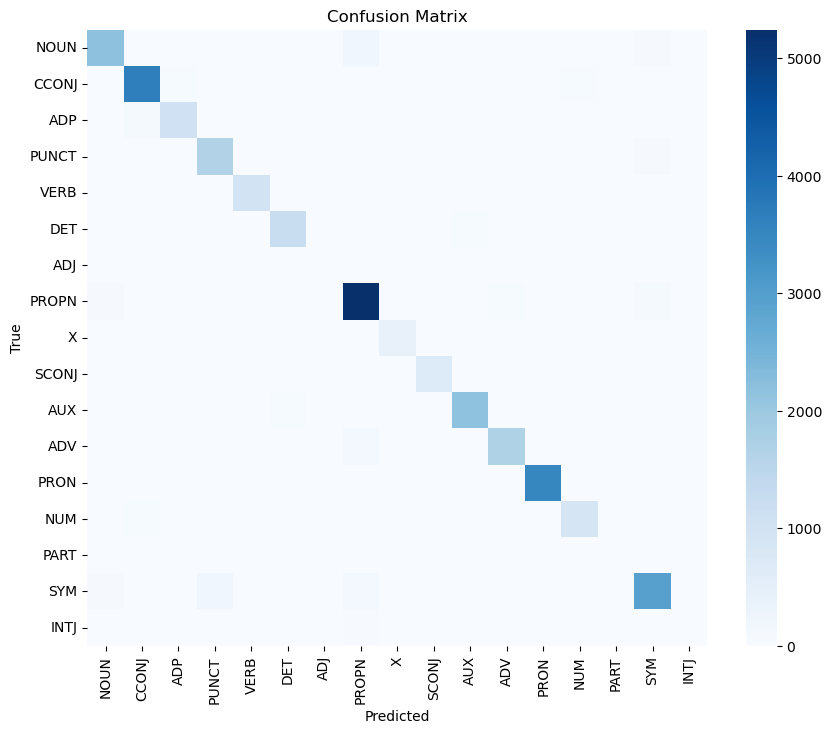

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(confusion_df, annot=False,  cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The most easily cofused values (although relatively low compared to those correctly predicted) are:
- NOUN with PROPN
- SYM with PUNCT
- SYM with PROPN
- ADV with PROPN

----

## Part 2 – Span identification with sequence models

In this part, you'll use the same sequence models for a different task: named entity recognition for English. The following code loads the training and test files:

In [28]:
def load_ner_data(filename):
	dataset_X, dataset_Y = [], []
	sent_X, sent_Y = [], []
	with open(filename, 'r') as ner_file:
		for line in ner_file:
			if line.strip() == "":
				if len(sent_X) > 0:
					dataset_X.append(sent_X)
					dataset_Y.append(sent_Y)
					sent_X = []
					sent_Y = []
			elif line.startswith("#") or line.startswith("-DOCSTART-"):
				continue
			else:
				elements = line.strip().split(" ")
				sent_X.append(elements[0])
				sent_Y.append(elements[3])
		if len(sent_X) > 0:
			dataset_X.append(sent_X)
			dataset_Y.append(sent_Y)
	print(f"{len(dataset_X)} sentences loaded from file {filename}")
	return dataset_X, dataset_Y

train_nerdata_x, train_nerdata_y = load_ner_data('ner-train.txt')
test_nerdata_x, test_nerdata_y = load_ner_data('ner-test.txt')

14041 sentences loaded from file ner-train.txt
3453 sentences loaded from file ner-test.txt


**Task 2.1** (1 point): Train a greedy tagger with the NER training data. Use any feature set that worked well for POS tagging, but *do not include transition features* for now. Compute the token-level accuracy of the test set, as before.

In [29]:
load_ner_data('ner-train.txt')

14041 sentences loaded from file ner-train.txt


([['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
  ['Peter', 'Blackburn'],
  ['BRUSSELS', '1996-08-22'],
  ['The',
   'European',
   'Commission',
   'said',
   'on',
   'Thursday',
   'it',
   'disagreed',
   'with',
   'German',
   'advice',
   'to',
   'consumers',
   'to',
   'shun',
   'British',
   'lamb',
   'until',
   'scientists',
   'determine',
   'whether',
   'mad',
   'cow',
   'disease',
   'can',
   'be',
   'transmitted',
   'to',
   'sheep',
   '.'],
  ['Germany',
   "'s",
   'representative',
   'to',
   'the',
   'European',
   'Union',
   "'s",
   'veterinary',
   'committee',
   'Werner',
   'Zwingmann',
   'said',
   'on',
   'Wednesday',
   'consumers',
   'should',
   'buy',
   'sheepmeat',
   'from',
   'countries',
   'other',
   'than',
   'Britain',
   'until',
   'the',
   'scientific',
   'advice',
   'was',
   'clearer',
   '.'],
  ['"',
   'We',
   'do',
   "n't",
   'support',
   'any',
   'such',
   'recommendation',
  

In [49]:
# Rerun to verify accuracy
tagger = GreedyTagger(feature_function=context_features_mk4)
tagger.fit(train_nerdata_x, train_nerdata_y)
model1_preds = tagger.predict(test_nerdata_x)

# Calculate accuracy
accuracy = tagging_accuracy(test_nerdata_y, model1_preds)
print(f"Accuracy: {accuracy}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9180574997308065


**Task 2.2** (1 point): Token-level accuracy is not well adapted to span identification tasks (why?). Instead, we want to compute precision, recall and f-score of the *entities*. Adapt the code below:


In span identification tasks, such as Named Entity Recognition (NER), token-level accuracy is insufficient for evaluating model performance due to its inability to account for entity boundaries and the correct classification of entire spans

In [45]:
def get_ranges(l):
    """
        Helper procedure for eval_ner.
        You're not expected to change anything here.
    """
    elements = []
    current_element = None
    current_start = None
    for i, ll in enumerate(l):
        if ll == 'O':
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = None
            current_start = -1
        elif ll[0] == 'B':
            if current_element != None:
                elements.append((current_element, current_start, i))
            current_element = ll[2:]
            current_start = i
        elif ll[0] == "I":
            if current_element != ll[2:]:
                elements.append((current_element, current_start, i))
                current_element = ll[2:]
                current_start = i
    return elements

def eval_ner(sys_labels, gold_labels):
    """
        Computes precision, recall and f1-score, using get_ranges() to identify the named entities.
        No need to edit this function.
    """
    tp, fp, fn = 0, 0, 0 ## fp = False positive, fn = False negative, tp = True positive
    for sys_l, gold_l in zip(sys_labels, gold_labels):
        sys_ranges = get_ranges(sys_l)
        gold_ranges = get_ranges(gold_l)
        for r in sys_ranges:
            if r in gold_ranges:
                tp += 1
            else:
                fp += 1  ## TODO: also count fp and fn --> done
                
        for r in gold_labels:
            if r not in sys_ranges:
                fn += 1
       
    
    ## TODO: compute recall, precision and f1-score from tp, fp and fn --> done
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    f1score = 2 * (prec * recall) / (prec + recall) if (prec + recall) > 0 else 0
    

    return recall, prec, f1score

Report precision, recall and f1-score of the model trained above.

In [50]:
accuracy = tagging_accuracy(test_nerdata_y, model1_preds)
print(f"Accuracy: {accuracy}")
recall, precision, f1_score = eval_ner(model1_preds, test_nerdata_y)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1_score}")

Accuracy: 0.9180574997308065
Recall: 0.00023159539797639958
Precision: 0.6212325686009896
F1-Score: 0.000463018182851446


**Task 2.3** (1 point): Train a new model with transition features and predict the development set labels using `predict_with_history`. How does this change affect the token-level (accuracy) and entity-level (recall, precision, f1-score) metrics?

In [51]:
tagger = GreedyTagger(feature_function=transition_features_mk2)
tagger.fit(train_nerdata_x, train_nerdata_y)
model2_preds = tagger.predict_with_history(test_nerdata_x)

# Calculate accuracy
accuracy = tagging_accuracy(test_nerdata_y, model2_preds)
print(f"Accuracy: {accuracy}")

recall, precision, f1_score = eval_ner(model2_preds, test_nerdata_y)
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1-Score: {f1_score}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9510498546355121
Recall: 0.00034777193304434505
Precision: 0.7829369573423933
F1-Score: 0.0006952350503722769


While the current model shows an improvement in token-level accuracy and precision, the span-level metrics (recall and F1-score) remain very low. The increased precision suggests the model is better at making correct predictions when it does predict an entity, but the recall remains poor, indicating that the model fails to capture a large portion of the entities. Despite the higher accuracy, the model's overall ability to identify entities correctly is still far from optimal.

____

**Task 2.4** (2 points): Take some 50 sentences from the test set and display the words, gold tags, and the predicted tags of the two systems. Can you identify error patterns that are typical for the two systems respectively?

In [53]:
def compare_predictions(test_data_X, test_data_Y, model1_preds, model2_preds, num_sentences=50):
    for i, (sentence_X, sentence_Y) in enumerate(zip(test_data_X[:num_sentences], test_data_Y[:num_sentences])):
        print(f"Sentence {i+1}:")
        print(f"{'Word':<15} {'Gold-Tag':<10} {'Model1-Pred':<15} {'Model2-Pred':<15}")
        print("="*55)
        for word, gold_tag, model1_pred, model2_pred in zip(sentence_X, sentence_Y, model1_preds[i], model2_preds[i]):
            print(f"{word:<15} {gold_tag:<10} {model1_pred:<15} {model2_pred:<15}")
        print("\n")

compare_predictions(test_nerdata_x, test_nerdata_y, model1_preds, model2_preds, num_sentences=50)

Sentence 1:
Word            Gold-Tag   Model1-Pred     Model2-Pred    
SOCCER          O          O               O              
-               O          O               O              
JAPAN           B-LOC      B-PER           B-PER          
GET             O          O               I-PER          
LUCKY           O          O               I-PER          
WIN             O          O               O              
,               O          O               O              
CHINA           B-PER      O               B-PER          
IN              O          O               O              
SURPRISE        O          O               O              
DEFEAT          O          O               O              
.               O          O               O              


Sentence 2:
Word            Gold-Tag   Model1-Pred     Model2-Pred    
Nadim           B-PER      O               B-PER          
Ladki           I-PER      O               I-PER          


Sentence 3:
Word            

We can recognize entity type confusion like in sentence 1 with the token 'japan' where the gold-tag is B-LOC but our models predict B-PER. Next we have entity boundaries error because Model 1 misses the person entity "Nadim Ladki" entirely, tagging it as O. Model 2 correctly identifies both parts of the name.

___

## Part 3: Text classification with feed-forward neural networks

For this part, we go back to the text classification task used in the first assignment: language identification of Bokmål and Nynorsk.

Instead of manually creating a bag-of-subwords matrix with the BPE-encoded data, we go a simpler route this time and use the `CountVectorizer` class provided by Scikit-Learn. Have a look at the documentation of `CountVectorizer` here: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

With the default parameters, `CountVectorizer` will tokenize the data at whitespaces, remove punctuation signs and convert everything to lowercase. You can play around with the parameters if you wish, but the default settings work decently well. A useful thing to make the vectors smaller is to remove hapaxes, i.e. words that occur only once in the training data. You can achieve this with `min_df=2`.

**Task 3.1** (2 points): Write the code to produce `train_X, train_Y, test_X, test_Y`. Each `*_X` variable should contain a list of vectors produced by `CountVectorizer`. Each `*_Y` variable should contain a list of integers (1 for Nynorsk and 0 for Bokmål).

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('ndt_train_class.txt', sep='\t', header=None, names=['text', 'label'])
df['label'] = df['label'].apply(lambda x: 1 if x.strip() == 'nno' else 0)
display(df.head())
print(df.shape)

,text,label
0,"Nokre refleksjonar på vegen, om Paulus og ""wor...",1
1,"Eg var på bibeltime i går, på Misjonshuset.",1
2,"Det var veldig triveleg, og vi fekk også god k...",1
3,Min gode ven Kjell Arne heldt bibeltime over k...,1
4,Det er eigentleg veldig spennande å lese Kol n...,1


(39712, 2)


In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(df['text'], df['label'], test_size=0.2, random_state=4357)

In [100]:
from sklearn.feature_extraction.text import CountVectorizer
  
vectorizer = CountVectorizer(min_df=2)

train_X_vectorized = vectorizer.fit_transform(train_X)
test_X_vectorized = vectorizer.transform(test_X)

now we need more data so we use also the test file that we got from assignment 1 (without splitting)

In [8]:
train_df = pd.read_csv('ndt_train_class.txt', sep='\t', header=None, names=['text', 'label'])
test_df = pd.read_csv('ndt_test_class.txt', sep='\t', header=None, names=['text', 'label'])

train_X = train_df['text']
train_Y = train_df['label'].apply(lambda x: 1 if x.strip() == 'nno' else 0)

test_X = test_df['text']
test_Y = test_df['label'].apply(lambda x: 1 if x.strip() == 'nno' else 0)

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
  
vectorizer = CountVectorizer(min_df=2)

train_X_vectorized = vectorizer.fit_transform(train_X)
test_X_vectorized = vectorizer.transform(test_X)

**Task 3.2** (1 point): Create a logistic regression classifier, train it on the training set, and predict the labels of the test set. Compute accuracy, precision and recall, as in the previous assignment. How do your results compare with the previous assignment?

In [116]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

model = LogisticRegression()
model.fit(train_X_vectorized, train_Y)
y_pred = model.predict(test_X_vectorized)

print("Confusion Matrix:")
print(confusion_matrix(test_Y, y_pred))

print("\nClassification Report:")
print(classification_report(test_Y, y_pred))

Confusion Matrix:
[[17825    78]
 [  506 17069]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17903
           1       1.00      0.97      0.98     17575

    accuracy                           0.98     35478
   macro avg       0.98      0.98      0.98     35478
weighted avg       0.98      0.98      0.98     35478



/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
accuracy = accuracy_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.98
Precision: 1.00
Recall: 0.97


Based on these results, we can say that the overall performance of the model has improved compared to last assignment.
___

**Task 3.3** (1 point): Let us use a simple feed-forward neural network classifier instead of logistic regression, but keep the input feature representation identical. Scikit-Learn provides a simple feed-forward classifier under the name `MLPClassifier`. The most important parameter is `hidden_layer_sizes`, which specifies the number and size of hidden layers. For example, `MLPClassifier(hidden_layer_sizes=(10, 5))` creates a classifier with two hidden layers, the first one with 10 neurons and the second one with 5 neurons. To start, keep the model simple and choose a single hidden layer with 10 neurons. How does this model perform in comparison with logistic regression?

In [119]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(hidden_layer_sizes=(10))
mlp_model.fit(train_X_vectorized, train_Y)
y_pred = mlp_model.predict(test_X_vectorized)

In [121]:
accuracy = accuracy_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.99
Precision: 1.00
Recall: 0.99


In [122]:
print("\nConfusion Matrix:")
print(confusion_matrix(test_Y, y_pred))

print("\nClassification Report:")
print(classification_report(test_Y, y_pred))


Confusion Matrix:
[[17852    51]
 [  156 17419]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     17903
           1       1.00      0.99      0.99     17575

    accuracy                           0.99     35478
   macro avg       0.99      0.99      0.99     35478
weighted avg       0.99      0.99      0.99     35478



This model takes longer to run but there has been an improvement in the results. the only thing that does not convince me is the value at the bottom left of the confusion matrix which is slightly higher than before.
___

**Task 3.4** (1 point): Try to improve the results by adding more and/or larger hidden layers. You're not expected to work with more than 50 neurons in total, as this slows down the training process drastically.

In [123]:
from sklearn.neural_network import MLPClassifier

mlp_model_mk2 = MLPClassifier(hidden_layer_sizes=(10, 5, 3)) # --> adding more and larger layers, but the results it's kinda the same of before
mlp_model_mk2.fit(train_X_vectorized, train_Y)
y_pred = mlp_model_mk2.predict(test_X_vectorized)

accuracy = accuracy_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.99
Precision: 0.99
Recall: 0.99


In [125]:
from sklearn.neural_network import MLPClassifier

mlp_model_mk2 = MLPClassifier(hidden_layer_sizes=(3,2)) # --> adding more and large layers
mlp_model_mk2.fit(train_X_vectorized, train_Y)
y_pred = mlp_model_mk2.predict(test_X_vectorized)

accuracy = accuracy_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Accuracy: 0.99
Precision: 1.00
Recall: 0.99


Now, let us see if we can improve the input representation. Instead of a bag-of-words model created with `CountVectorizer`, we will obtain document embeddings from a pretrained Norwegian SentenceBert model (in particular, the [base model from the National Library of Norway](https://huggingface.co/NbAiLab/nb-sbert-base)). The following snippet shows how to load and use such a model.

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('NbAiLab/nb-sbert-base')
sentences = ["This is a Norwegian boy", "Dette er en norsk gutt", "Dette er ein norsk gut"]
embeddings = model.encode(sentences)
print(embeddings)

/opt/anaconda3/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


tokenizer_config.json:   0%|          | 0.00/377 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[ 1.4281033   0.39518782  0.0626261  ...  1.1759279   0.596934
  -0.12693603]
 [ 1.4975809  -0.5266639  -0.03449092 ...  1.3204104   0.8549468
   0.14108083]
 [ 1.5804617  -0.11839686 -0.08846243 ...  1.2216041   0.9193567
   0.16344203]]


**Task 3.5** (1 point): Produce embeddings for the training and test sets and train a new `MLPClassifier` with these embeddings as input features. Can you further improve the evaluation scores?

Note: Producing the embeddings and training the model will take longer than in previous exercises, around 10 minutes.

In [11]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('NbAiLab/nb-sbert-base')

X_train_embeddings = model.encode(train_X)
X_test_embeddings = model.encode(test_X)

mlp_model = MLPClassifier(hidden_layer_sizes=1)
mlp_model.fit(X_train_embeddings, train_Y)
y_pred = mlp_model.predict(X_test_embeddings)

accuracy = accuracy_score(test_Y, y_pred)
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)

# not able to run

KeyboardInterrupt: 